In [90]:
### TO-DOs ###
# DBSCAN get value_counts for epsilons in range(12,18)
# Export datasets with: school_name, school_address, label, score (e.g. silhouette_coefficient)

## Imports

#### Import packages

In [91]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
viz_config = {'color': 'c', 'alpha': 0.4}
sns.set_context('paper')

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.cm as cm

random_state=42

#### Import data

In [92]:
school_data = pd.read_csv('raw_data/schools.csv', header=0, index_col=0)

In [93]:
income_data = pd.read_csv('raw_data/incomes.csv', header=0, names=['zip', 'income'])

## Exploratory Data Analysis

#### School data

In [94]:
school_data.head()

Address  \
A.N. Pritzker School                                 2009 W Schiller St, Chicago, IL 60622   
ACE Technical Charter School                            5410 S State St, Chicago, IL 60609   
ASPIRA Business and Finance                        2989 N Milwaukee Ave, Chicago, IL 60618   
ASPIRA Charter School - Early College High School      3986 W Barry Ave, Chicago, IL 60618   
ASPIRA Charter School - Haugan Middle School          3729 W Leland Ave, Chicago, IL 60625   

                                                   Ambitious_Instruction  \
A.N. Pritzker School                                                  63   
ACE Technical Charter School                                          79   
ASPIRA Business and Finance                                           55   
ASPIRA Charter School - Early College High School                     72   
ASPIRA Charter School - Haugan Middle School                          99   

                                                   Collaborative_Teachers  \
A.N. Pritzker School                                                   46   
ACE Technical Charter School                                           71   
ASPIRA Business and Finance                                            32   
ASPIRA Charter School - Early College High School                      64   
ASPIRA Charter School - Haugan Middle School                           87   

                                                   Effective_Leaders  \
A.N. Pritzker School                                              42   
ACE Technical Charter School                                      65   
ASPIRA Business and Finance                                       16   
ASPIRA Charter School - Early College High School                 52   
ASPIRA Charter School - Haugan Middle School                      80   

                                                   Involved_Families  \
A.N. Pritzker School                                              70   
ACE Technical Charter School                                      70   
ASPIRA Business and Finance                                       25   
ASPIRA Charter School - Early College High School                 75   
ASPIRA Charter School - Haugan Middle School                      80   

                                                   Supportive_Environment  
A.N. Pritzker School                                                   45  
ACE Technical Charter School                                           46  
ASPIRA Business and Finance                                            49  
ASPIRA Charter School - Early College High School                      64  
ASPIRA Charter School - Haugan Middle School                           60

There is a mistake in the data: the zip code for George Washington Carver Military Academy HS is supposed to be 60827, not 60627.

In [95]:
# Function to extract zip code out of an address
get_zip = lambda x: x.split()[-1]

# View the problematic entry
cond_zip_60627 = school_data['Address'].apply(get_zip) == '60627'
school_data.loc[cond_zip_60627]

Address  \
George Washington Carver Military Academy HS  13100 S Doty Ave, Chicago, IL 60627   

                                              Ambitious_Instruction  \
George Washington Carver Military Academy HS                     75   

                                              Collaborative_Teachers  \
George Washington Carver Military Academy HS                      74   

                                              Effective_Leaders  \
George Washington Carver Military Academy HS                 59   

                                              Involved_Families  \
George Washington Carver Military Academy HS                 82   

                                              Supportive_Environment  
George Washington Carver Military Academy HS                      56

In [96]:
# Replace zip code with correct one: 60827
school_data.loc[cond_zip_60627, 'Address'] = '13100 S Doty Ave, Chicago, IL 60827'

# Check that the replacement worked
school_data.loc[cond_zip_60627]

Address  \
George Washington Carver Military Academy HS  13100 S Doty Ave, Chicago, IL 60827   

                                              Ambitious_Instruction  \
George Washington Carver Military Academy HS                     75   

                                              Collaborative_Teachers  \
George Washington Carver Military Academy HS                      74   

                                              Effective_Leaders  \
George Washington Carver Military Academy HS                 59   

                                              Involved_Families  \
George Washington Carver Military Academy HS                 82   

                                              Supportive_Environment  
George Washington Carver Military Academy HS                      56

In [97]:
school_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, A.N. Pritzker School to Young Women's Leadership Charter School
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Address                 655 non-null    object
 1   Ambitious_Instruction   655 non-null    int64 
 2   Collaborative_Teachers  655 non-null    int64 
 3   Effective_Leaders       655 non-null    int64 
 4   Involved_Families       655 non-null    int64 
 5   Supportive_Environment  655 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 35.8+ KB


In [98]:
school_data.describe()

Ambitious_Instruction  Collaborative_Teachers  Effective_Leaders  \
count             655.000000              655.000000         655.000000   
mean               69.600000               59.981679          53.824427   
std                23.629764               19.359696          17.555800   
min                -1.000000               -1.000000          -1.000000   
25%                61.500000               49.000000          44.000000   
50%                74.000000               62.000000          56.000000   
75%                86.000000               73.000000          66.000000   
max                99.000000               99.000000          98.000000   

       Involved_Families  Supportive_Environment  
count         655.000000              655.000000  
mean           61.665649               50.581679  
std            21.361594               21.584674  
min            -1.000000               -1.000000  
25%            51.000000               39.500000  
50%            63.000000               51.000000  
75%            77.000000               63.000000  
max            99.000000               99.000000

The web-crawling 'spider' inserted -1 for missing values. Schools that didn't have numbers for any of the categories were skipped in the process.

In [99]:
# Replace -1 with NaN
school_data[(school_data == -1)] = np.NaN

In [100]:
# Count NaNs by column
school_data.isna().sum()

Address                    0
Ambitious_Instruction     43
Collaborative_Teachers    14
Effective_Leaders         15
Involved_Families         24
Supportive_Environment    43
dtype: int64

In [101]:
# Count rows with too many NaNs
max_nans_allowed = 2
rows_too_many_nans = school_data.isna().sum(axis=1) > max_nans_allowed
len(school_data[rows_too_many_nans])

15

If we allow a maximum of 1 missing value per row, we lose 58 instances... almost 10% of our dataset. With max_nans_allowed set at 2, we only lose 15 instances.

In [102]:
# New DataFrame without too many NaNs on each row
school_df = school_data[~rows_too_many_nans]

In [103]:
# Create separate Series for addresses
school_addresses = school_df.iloc[:, 0]

# Discard 'Address' column from DataFrame
school_df = school_df.iloc[:, 1:]

school_addresses

A.N. Pritzker School                                       2009 W Schiller St, Chicago, IL 60622
ACE Technical Charter School                                  5410 S State St, Chicago, IL 60609
ASPIRA Business and Finance                              2989 N Milwaukee Ave, Chicago, IL 60618
ASPIRA Charter School - Early College High School            3986 W Barry Ave, Chicago, IL 60618
ASPIRA Charter School - Haugan Middle School                3729 W Leland Ave, Chicago, IL 60625
                                                                        ...                     
YCCS - Sullivan House Alternative HS                 8164 S South Chicago Ave, Chicago, IL 60617
YCCS - Truman Middle College HS                             1145 W Wilson Ave, Chicago, IL 60640
YCCS - West Town Acad Alternative HS                    500 N Sacramento Blvd, Chicago, IL 60612
YCCS - Youth Connection Leadership Acad HS                    3424 S State St, Chicago, IL 60616
Young Women's Leadership Chart

In [104]:
school_df.describe()

Ambitious_Instruction  Collaborative_Teachers  Effective_Leaders  \
count             598.000000              640.000000         639.000000   
mean               74.760870               61.329687          55.100156   
std                14.790486               17.325542          15.606324   
min                32.000000               16.000000           4.000000   
25%                64.000000               50.000000          46.000000   
50%                75.000000               63.000000          56.000000   
75%                87.000000               74.000000          66.000000   
max                99.000000               99.000000          98.000000   

       Involved_Families  Supportive_Environment  
count         631.000000              598.000000  
mean           64.049128               54.170569  
std            17.844099               17.344408  
min             7.000000               12.000000  
25%            52.000000               42.000000  
50%            64.000000               53.000000  
75%            78.000000               64.000000  
max            99.000000               99.000000

In [105]:
# Fill NaNs with their respective row's mean
school_df = school_df.apply(lambda row: row.fillna(row.median()), axis=1)

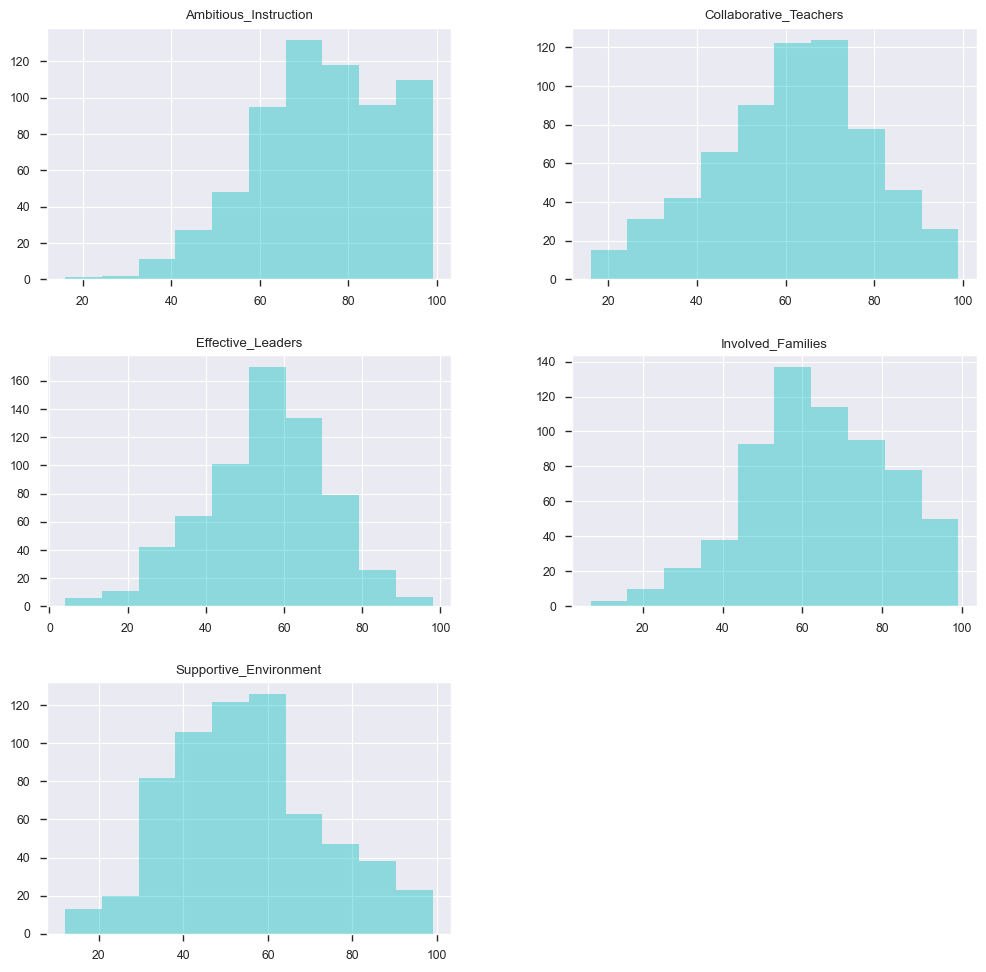

In [106]:
school_df.hist(figsize=(12,12), **viz_config);

#### Income data

In [107]:
income_data.head()

zip   income
0  60007  75743.0
1  60018  60566.0
2  60106  67325.0
3  60131  57815.0
4  60176  53360.0

In [108]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   zip     68 non-null     int64  
 1   income  67 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [109]:
income_data.isna().sum()

zip       0
income    1
dtype: int64

In [110]:
# Find rows with income NaN
cond_isna = income_data.iloc[:, 1].isna()
income_data.loc[cond_isna]

zip  income
44  60642     NaN

In [111]:
# Find rows with income 0
cond_zero = income_data.iloc[:, 1] == 0
income_data.loc[cond_zero]

zip  income
54  60654     0.0
61  60666     0.0

In [112]:
# Calculate median for the income column
income_median = income_data.iloc[:,1].median()

# Assign income_median to the locations where conditions return True
income_data.iloc[(cond_isna | cond_zero).values, 1] = income_median

In [113]:
# Describe the income column
income_data.iloc[:,1].describe()

count        68.000000
mean      56778.794118
std       23573.079579
min       18464.000000
25%       42493.250000
50%       54344.000000
75%       63822.500000
max      171463.000000
Name: income, dtype: float64

### Join dataframes

In [114]:
# Create zip column in school_df to use in the merge
school_df['zip'] = school_addresses.apply(lambda x: x.split()[-1])
school_df['zip'] = school_df['zip'].astype('int64')
school_df.head()

Ambitious_Instruction  \
A.N. Pritzker School                                                63.0   
ACE Technical Charter School                                        79.0   
ASPIRA Business and Finance                                         55.0   
ASPIRA Charter School - Early College High School                   72.0   
ASPIRA Charter School - Haugan Middle School                        99.0   

                                                   Collaborative_Teachers  \
A.N. Pritzker School                                                 46.0   
ACE Technical Charter School                                         71.0   
ASPIRA Business and Finance                                          32.0   
ASPIRA Charter School - Early College High School                    64.0   
ASPIRA Charter School - Haugan Middle School                         87.0   

                                                   Effective_Leaders  \
A.N. Pritzker School                                            42.0   
ACE Technical Charter School                                    65.0   
ASPIRA Business and Finance                                     16.0   
ASPIRA Charter School - Early College High School               52.0   
ASPIRA Charter School - Haugan Middle School                    80.0   

                                                   Involved_Families  \
A.N. Pritzker School                                            70.0   
ACE Technical Charter School                                    70.0   
ASPIRA Business and Finance                                     25.0   
ASPIRA Charter School - Early College High School               75.0   
ASPIRA Charter School - Haugan Middle School                    80.0   

                                                   Supportive_Environment  \
A.N. Pritzker School                                                 45.0   
ACE Technical Charter School                                         46.0   
ASPIRA Business and Finance                                          49.0   
ASPIRA Charter School - Early College High School                    64.0   
ASPIRA Charter School - Haugan Middle School                         60.0   

                                                     zip  
A.N. Pritzker School                               60622  
ACE Technical Charter School                       60609  
ASPIRA Business and Finance                        60618  
ASPIRA Charter School - Early College High School  60618  
ASPIRA Charter School - Haugan Middle School       60625

In [115]:
merged_df = pd.merge(school_df, income_data, how='left', on='zip')
merged_df.head()

Ambitious_Instruction  Collaborative_Teachers  Effective_Leaders  \
0                   63.0                    46.0               42.0   
1                   79.0                    71.0               65.0   
2                   55.0                    32.0               16.0   
3                   72.0                    64.0               52.0   
4                   99.0                    87.0               80.0   

   Involved_Families  Supportive_Environment    zip   income  
0               70.0                    45.0  60622  54344.0  
1               70.0                    46.0  60609  31357.0  
2               25.0                    49.0  60618  55303.0  
3               75.0                    64.0  60618  55303.0  
4               80.0                    60.0  60625  53288.0

In [116]:
merged_df.describe()

Ambitious_Instruction  Collaborative_Teachers  Effective_Leaders  \
count             640.000000              640.000000         640.000000   
mean               74.139062               61.329687          55.126562   
std                15.274362               17.325542          15.608410   
min                16.000000               16.000000           4.000000   
25%                64.000000               50.000000          46.000000   
50%                75.000000               63.000000          56.000000   
75%                87.000000               74.000000          66.000000   
max                99.000000               99.000000          98.000000   

       Involved_Families  Supportive_Environment           zip        income  
count         640.000000              640.000000    640.000000    640.000000  
mean           63.998438               54.900000  60630.142188  45439.895312  
std            17.861929               17.665099     22.821964  13279.991805  
min             7.000000               12.000000  60602.000000  18464.000000  
25%            52.000000               42.000000  60618.000000  34670.000000  
50%            64.000000               53.000000  60625.000000  45717.000000  
75%            78.000000               66.000000  60639.000000  54344.000000  
max            99.000000               99.000000  60827.000000  93702.000000

In [117]:
# Delete the zip column
merged_df.drop('zip', axis=1, inplace=True)

#### Scale income

All features except for income have similar ranges: 0 to 100 (or 99 if we want to be precise). In order for the clustering algorithms to properly detect patterns in the data, we want income to be in the same range.

In [118]:
max_income = max(merged_df['income'])

merged_df['income'] = (merged_df['income'] / max_income) * 100

In [119]:
merged_df.describe()

Ambitious_Instruction  Collaborative_Teachers  Effective_Leaders  \
count             640.000000              640.000000         640.000000   
mean               74.139062               61.329687          55.126562   
std                15.274362               17.325542          15.608410   
min                16.000000               16.000000           4.000000   
25%                64.000000               50.000000          46.000000   
50%                75.000000               63.000000          56.000000   
75%                87.000000               74.000000          66.000000   
max                99.000000               99.000000          98.000000   

       Involved_Families  Supportive_Environment      income  
count         640.000000              640.000000  640.000000  
mean           63.998438               54.900000   48.494051  
std            17.861929               17.665099   14.172581  
min             7.000000               12.000000   19.705022  
25%            52.000000               42.000000   37.000277  
50%            64.000000               53.000000   48.789780  
75%            78.000000               66.000000   57.996628  
max            99.000000               99.000000  100.000000

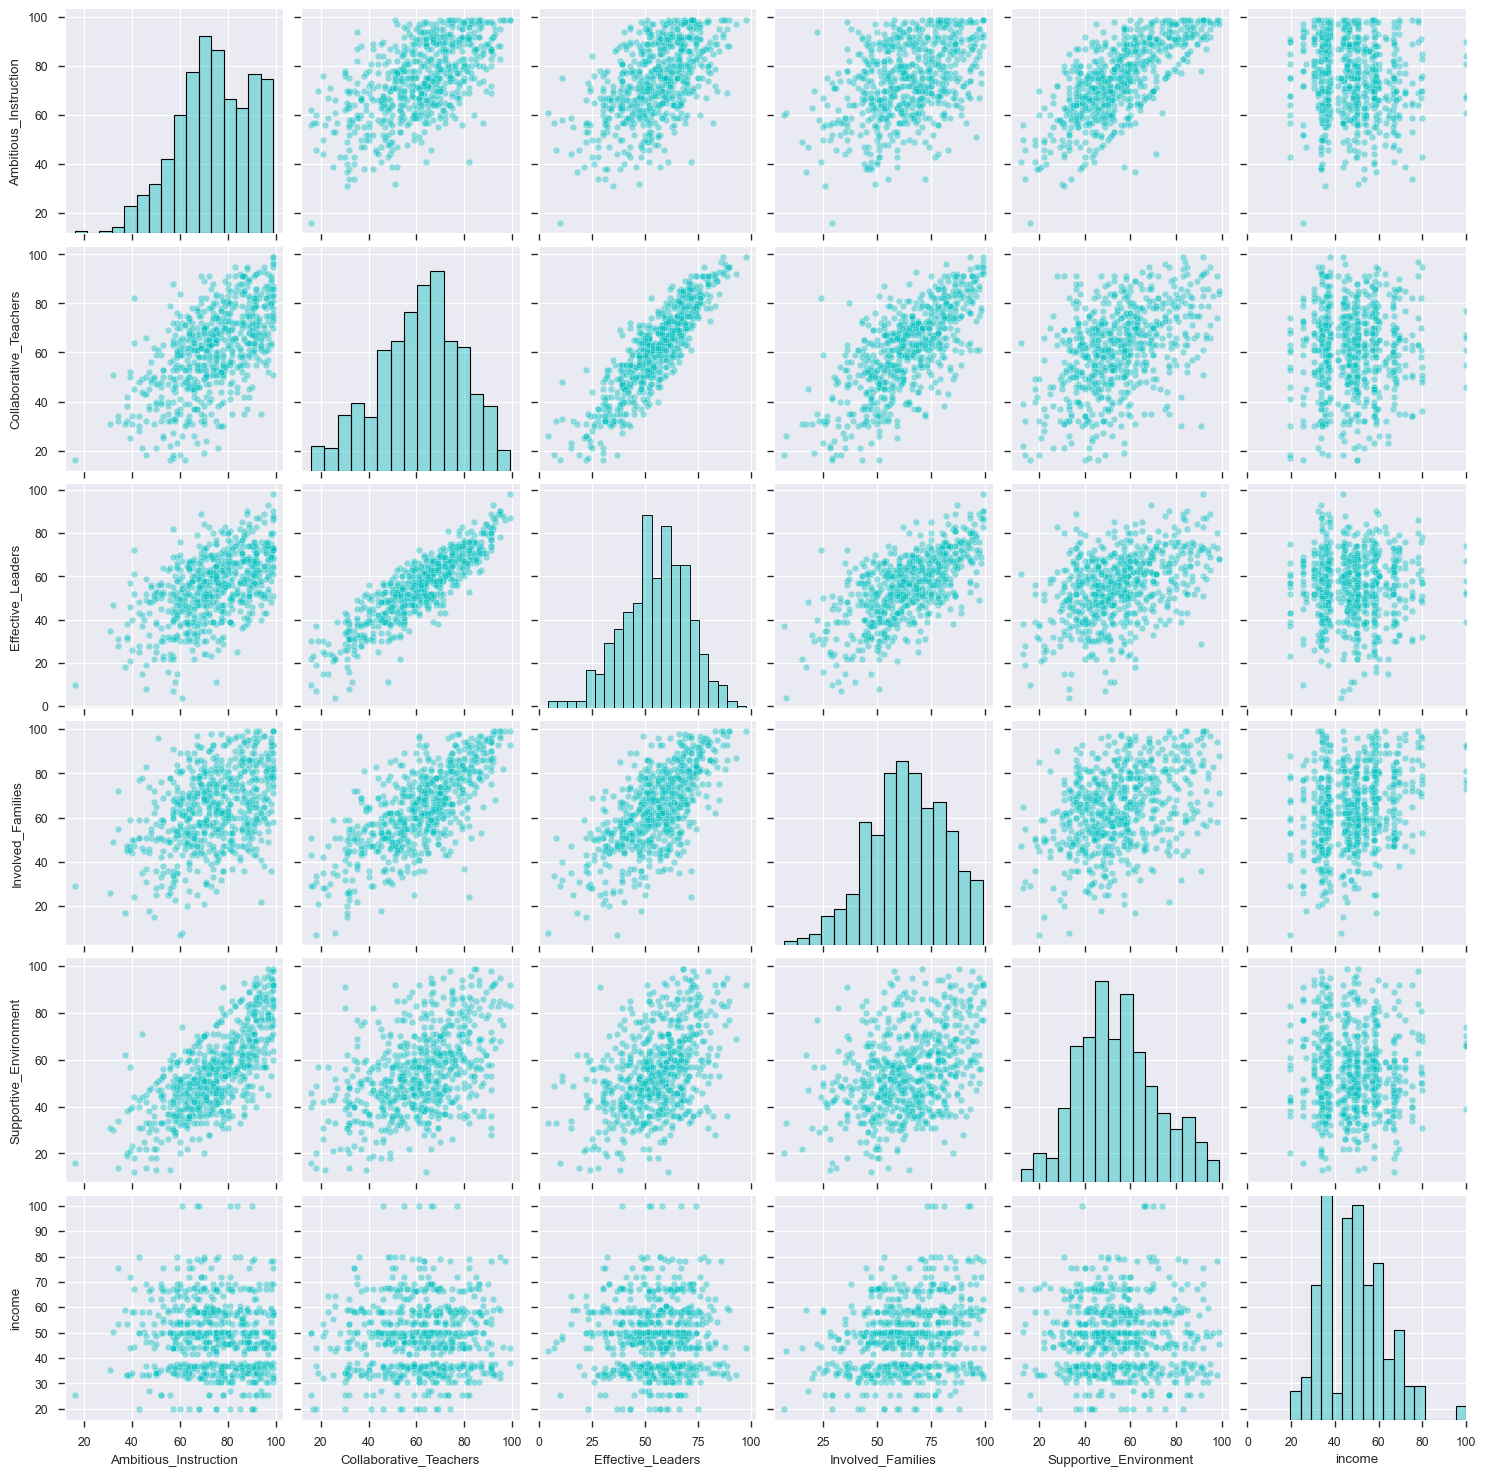

In [120]:
sns.pairplot(merged_df,
             diag_kind='hist', 
             plot_kws=viz_config,
             diag_kws=viz_config)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show();

In [121]:
columns = list(merged_df.columns)

In [122]:
get_fresh_X = lambda : merged_df.values

In [123]:
X = get_fresh_X()

### K-Means

In [124]:
k=5
kmeans = KMeans(n_clusters=k, random_state=random_state)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [125]:
kmeans.cluster_centers_

array([[85.08088235, 60.95588235, 54.83823529, 57.85294118, 65.69852941,
        39.71649171],
       [62.70700637, 52.39490446, 47.46496815, 55.19426752, 42.98726115,
        49.73684021],
       [91.05172414, 82.20689655, 72.99137931, 84.3362069 , 76.07758621,
        48.32514707],
       [72.42675159, 69.17834395, 62.07643312, 74.89171975, 49.82165605,
        57.23448112],
       [55.40540541, 31.59459459, 29.16216216, 38.97972973, 37.90540541,
        43.70993264]])

In [126]:
# Clusters assigned to first 20 instances
kmeans.labels_[:20]

array([1, 3, 4, 3, 2, 3, 2, 1, 1, 1, 2, 4, 1, 1, 3, 4, 4, 3, 4, 1],
      dtype=int32)

In [127]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=random_state).fit(X) for k in range(2,11)]

In [128]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]

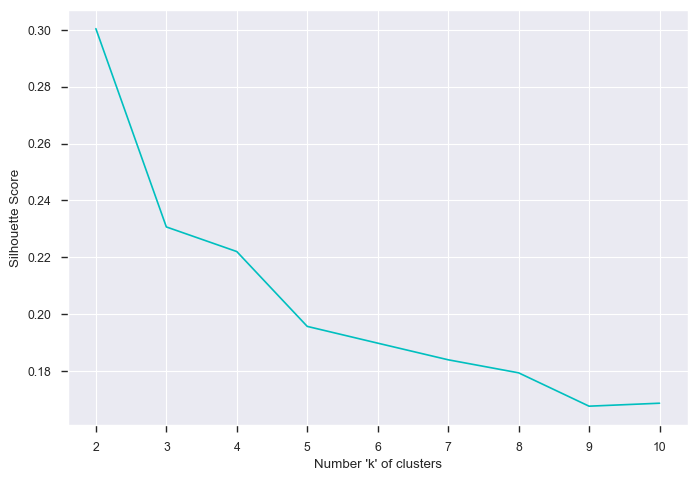

In [129]:
plt.plot(range(2,11), silhouette_scores, color='c')
plt.xlabel('Number \'k\' of clusters')
plt.ylabel('Silhouette Score');

In [130]:
def get_cluster_counts(model_class, param, values, additional_params={}):
    '''
    Given a model class and a parameter with a list of values, 
    get the resulting number of clusters
    '''
    cluster_counts = []
    
    print(param + ':')
    for value in values:
        print(str(value) + ' ', end='')
        param_dict = {param: value}
        param_dict.update(additional_params)
        model = model_class(**param_dict).fit(X)
        cluster_count = len(model.cluster_centers_)
        cluster_counts.append(cluster_count)

    print('')
    print('Cluster counts:')
    print(cluster_counts)
    return cluster_counts

In [131]:
def get_final_params(initial_param_values, cluster_counts, min_clusters=2, max_clusters=10):
    '''
    Given an initial list of parameter values and how many clusters were formed for each of them, 
    return a list of unique parameter values that caused a number of clusters within a range.
    '''
    range_clusters = range(min_clusters, max_clusters + 1)
    final_values = []
    
    for i in range_clusters:
        # Find the index in param_values where cluster_counts equals i
        idx = np.argmax(np.array(cluster_counts) == i)
        if idx == 0: # No cluster_counts are less than i, so np.argmax returned 0
            continue
        
        value = initial_param_values[idx] # Value of parameter at index idx in param_values
        print('parameter value: ' + str(value), '--- ' + 'number of clusters: ' + str(i))
        
        final_values.append(value)
        
    final_values.sort()
    return final_values

In [132]:
def scatter_labels(model, labels, centers=None, X=X, x=0, y=1, cmap=cm.Set2, ax=None, title=False):
    '''
    Make a scatter plot with colored clusters.
    '''
    # Model name
    name = model.__class__.__name__
    
    # Prepare colors
    n_clusters = len(set(labels))
    colors = cmap(labels.astype(float) / n_clusters)

    # Make figure    
    if not ax:
        fig, ax = plt.subplots()
    ax.scatter(X[:, x], X[:, y], c=colors, s=4)
    ax.set_xlabel(merged_df.columns[x])
    ax.set_ylabel(merged_df.columns[y])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0,102])
    ax.set_ylim([0,102])

    if title:
        ax.set_title(f'Model: {name}, Clusters: {n_clusters}', fontweight='bold')
    else:
        ax.set_title(f'Clusters: {n_clusters}')
    
    if centers is not None:
        # Draw white circles at cluster centers
        ax.scatter(centers[:, x], centers[:, y], marker='o',
                    c="white", alpha=1, s=100, edgecolor='k')

        for i, c in enumerate(centers):
            ax.scatter(c[x], c[y], marker='$%d$' % i, alpha=1,
                        s=25, edgecolor='k')

In [158]:
def plot_params(model_class, param, param_values, additional_params={}, figsize=(12,12)):
    '''
    Create a grid of cluster-colored scatter plots corresponding to different paramater values for a model.
    '''
    col_tuples = [(0, 1), (2, 3), (4, 5)]
    n_values = len(param_values)
    fig, ax_rows = plt.subplots(3, n_values, figsize=figsize)
    fig.suptitle(model_class.__name__, fontweight='bold')
    
    for value_idx, value in enumerate(param_values):
        # Build dictionary with parameters
        param_dict = {param: value}
        param_dict.update(additional_params)
        
        # Fit the model
        model = model_class(**param_dict).fit(X)
            
        # Get labels
        try: 
            labels = model.labels_
        except:
            labels = model.predict(X)
            
        # Get cluster centers
        try:
            centers = model.cluster_centers_
        except:
            centers = None
        
        row = value_idx
        for x, y in col_tuples:
            plt.tight_layout()
            col = x // 2
            ax = ax_rows[col][row]
            scatter_labels(model, labels=labels, centers=centers, x=x, y=y, ax=ax)

In [134]:
### BASED ON https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html###

def plot_silhouettes(X, n_clusters, labels, ax=None, title='', low_x=-0.1):
    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_xlim([low_x, 1])
    silhouette_avg = silhouette_score(X, labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)
    
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Set2(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, silhouette_avg, 1])

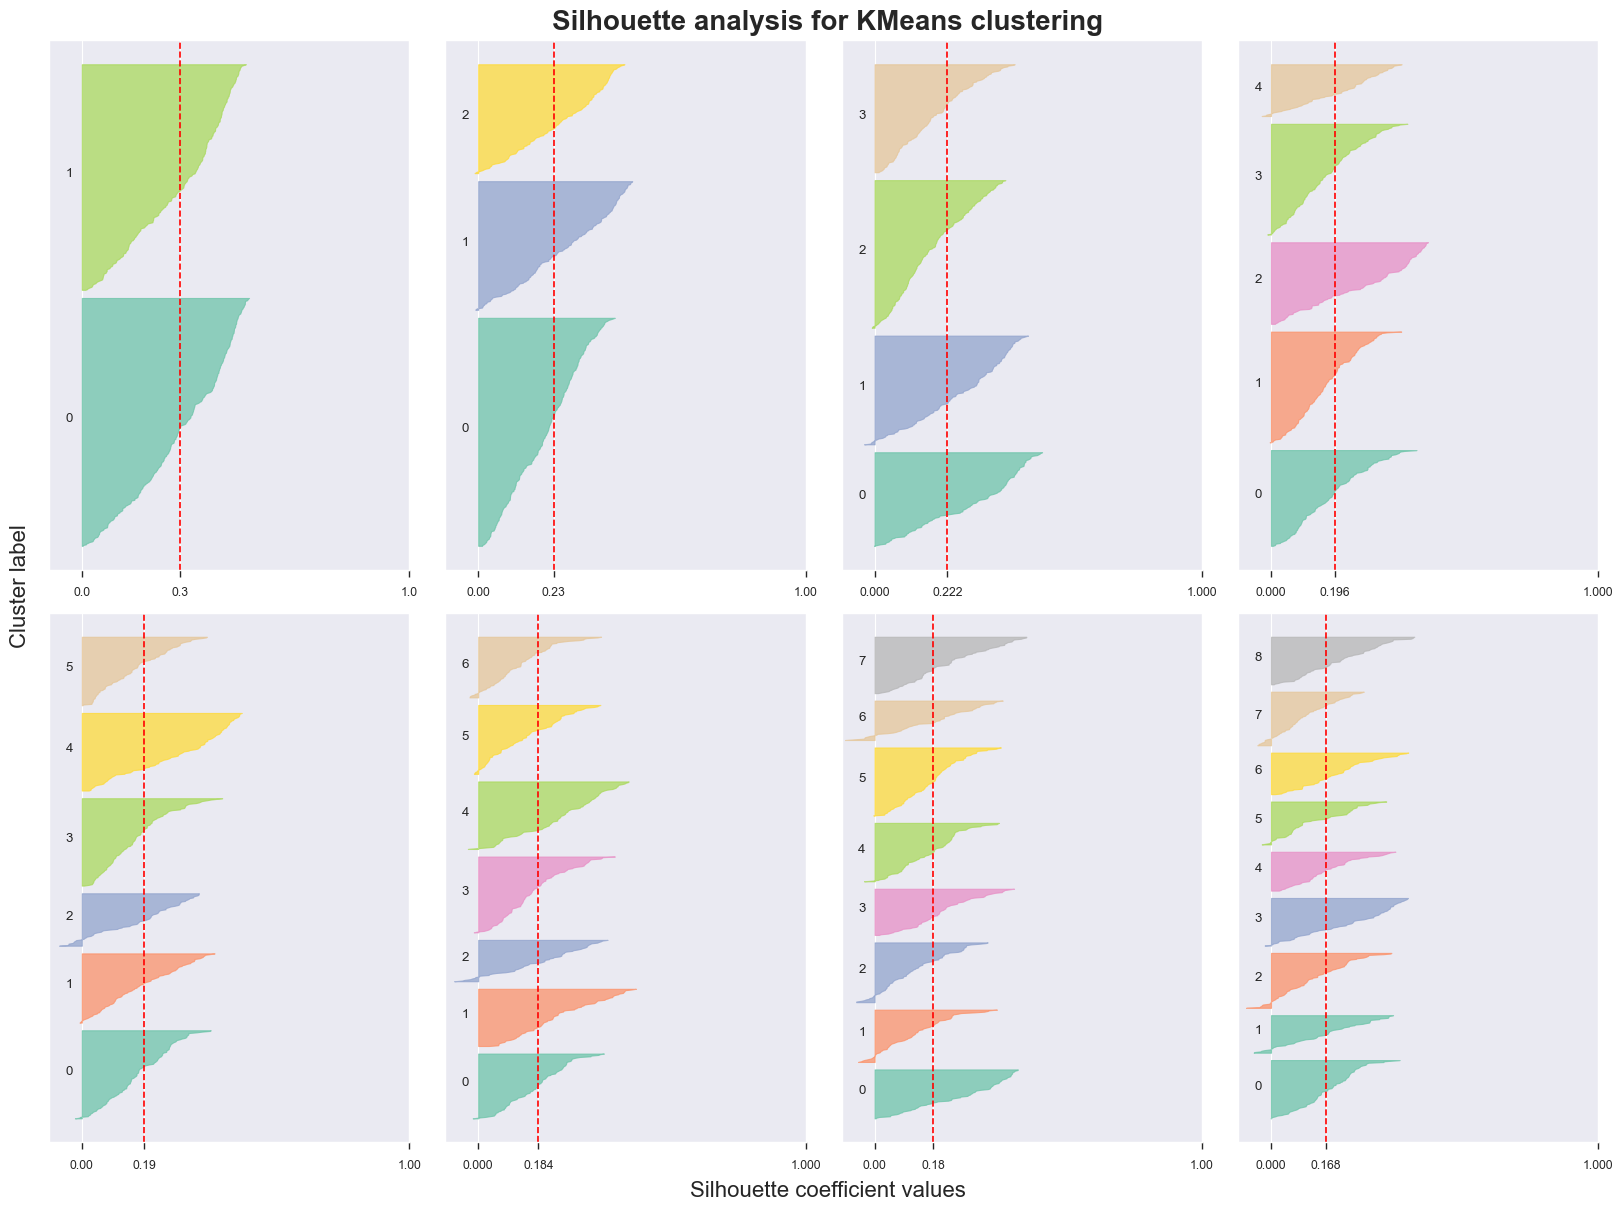

In [135]:
range_n_clusters = range(2,10)
indices = np.array(range_n_clusters) - np.array(range_n_clusters)[0]

fig, axs = plt.subplots(2, 4, figsize=(16, 12))
axs = axs.flatten()

fig.suptitle("Silhouette analysis for KMeans clustering",
                 fontsize=20, fontweight='bold')

fig.text(0.5, -0.004, "Silhouette coefficient values", ha="center", va="center", size=16)
fig.text(-0.005, 0.5, "Cluster label", ha="center", va="center", rotation=90, size=16)

for idx, n in zip(indices, range_n_clusters):
    model = KMeans(n_clusters=n, random_state=random_state)
    labels = model.fit_predict(X)
    ax = axs[idx]
    plot_silhouettes(X, n, labels, ax=ax)
    
plt.tight_layout()
    
plt.show()

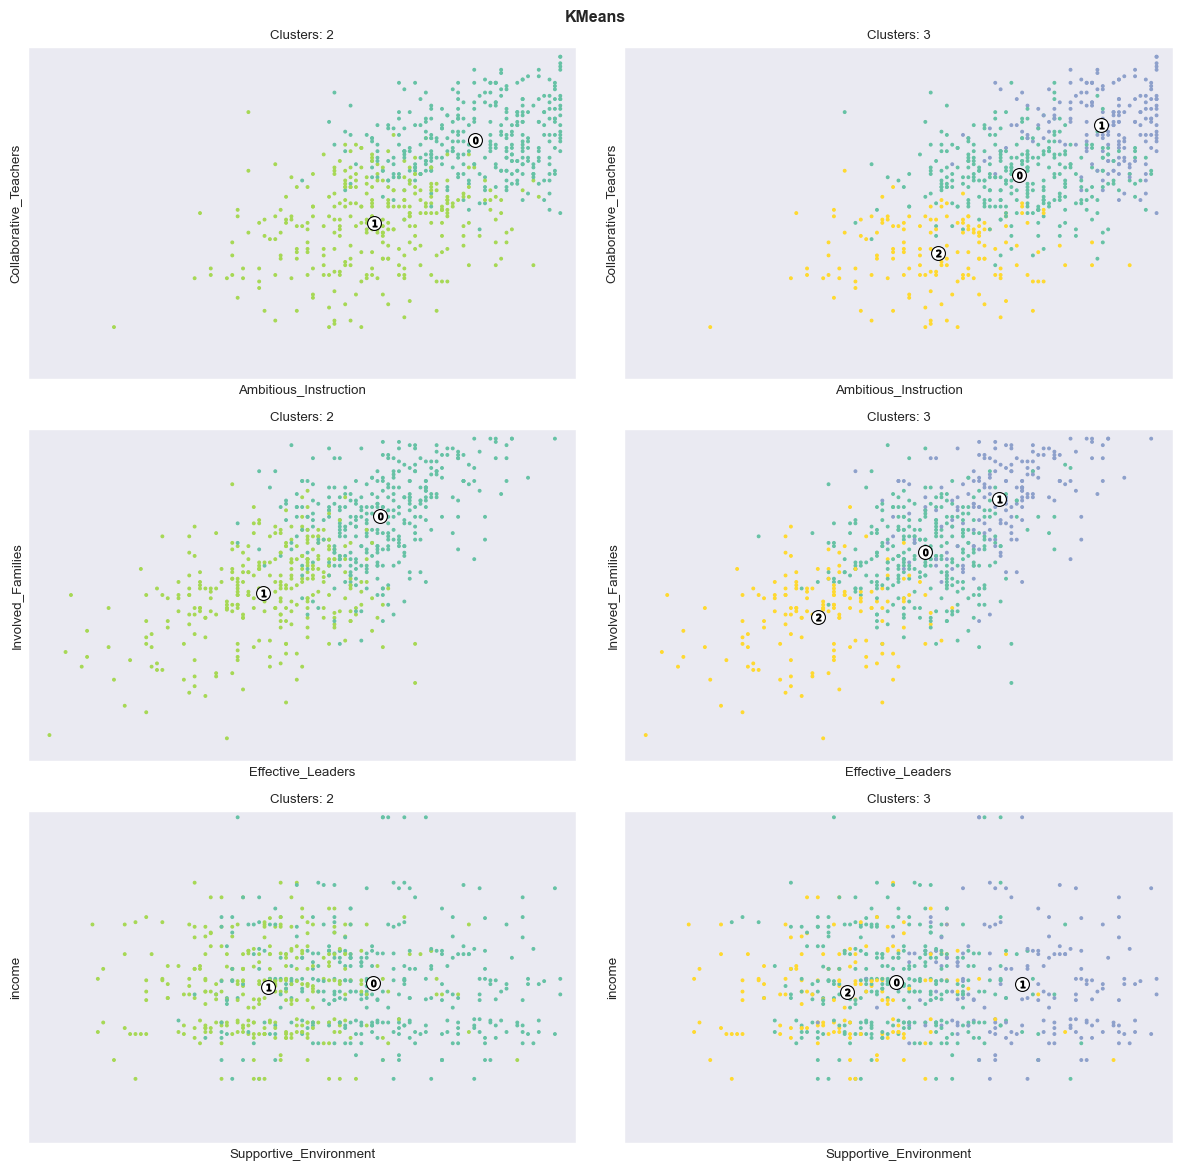

In [136]:
plot_params(KMeans, 'n_clusters', [2, 3], {'random_state': random_state}, figsize=(12,12))

### DBSCAN

A big challenge when using DBSCAN is tuning the hyperparameters (epsilon and min_samples).

In [137]:
### Reference: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#
# Get distance to nearest neighbor for each instance. n_neighbors includes the instance itself.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# 0th column is all 0s: distance between each instance and itself
# 1st column is distance between each distance and its closest neighbor
# Here is a (sorted) list of those distances for 20 instances
distances = np.sort(distances[:,1], axis=0)
distances[:20]

array([2.09486124, 2.09486124, 4.35889894, 4.35889894, 4.47940371,
       4.47940371, 4.51535642, 5.07563736, 5.07563736, 5.2824968 ,
       5.2824968 , 5.31696127, 5.31696127, 5.3263842 , 5.3263842 ,
       5.61147354, 5.61147354, 5.83652787, 5.83652787, 5.85864328])

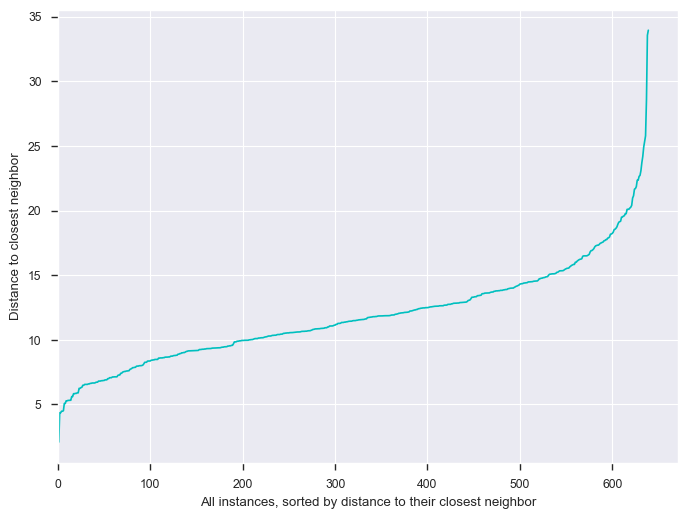

In [138]:
plt.figure(figsize=(8,6))
plt.plot(distances, color='c')
plt.xlim(0)
plt.xlabel('All instances, sorted by distance to their closest neighbor')
plt.ylabel('Distance to closest neighbor')
plt.show();

Ideal epsilon to cluster as many instances as possible while discarding outliers is between 12 and 17. I will choose 15 for now.

In [139]:
### Reference: https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289
dbscan = DBSCAN(eps=18, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=18)

In [140]:
pd.Series(dbscan.labels_).value_counts()

 0    568
-1     72
dtype: int64

### Explore the outliers

In [141]:
outliers_df = merged_df[dbscan.labels_ == -1]
outliers_df

Ambitious_Instruction  Collaborative_Teachers  Effective_Leaders  \
5                     68.0                    77.0               74.0   
11                    43.0                    28.0               25.0   
18                    62.0                    16.0               30.0   
34                    70.0                    49.0               57.0   
53                    85.0                    54.0               57.0   
..                     ...                     ...                ...   
628                   41.0                    82.0               72.0   
630                   67.0                    23.0               29.0   
631                   47.0                    45.0               48.0   
633                   57.0                    18.0                7.0   
636                   62.0                    48.0               45.0   

     Involved_Families  Supportive_Environment      income  
5                 92.0                    66.0  100.000000  
11                51.0                    22.0   49.957311  
18                51.0                    46.0   49.957311  
34                79.0                    70.0   79.928924  
53                84.0                    54.0   79.928924  
..                 ...                     ...         ...  
628               24.0                    44.0   44.514525  
630               25.0                    57.0   57.996628  
631               18.0                    47.0   26.970609  
633               33.5                    49.0   43.874197  
636               32.0                    64.0   47.394933  

[72 rows x 6 columns]

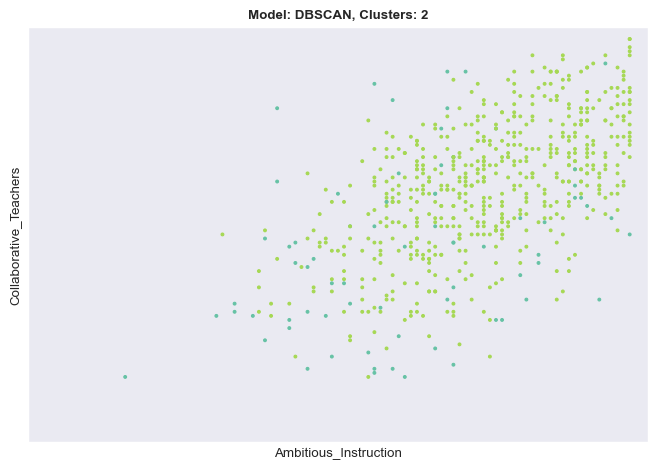

In [142]:
scatter_labels(dbscan, (dbscan.labels_ + 1), title=True)

### Aggloremative Clustering

In [143]:
X = get_fresh_X()

In [144]:
mergings = linkage(X, 'ward')

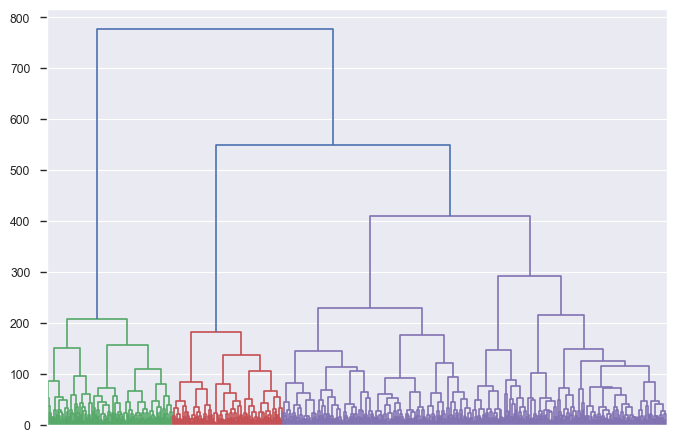

In [145]:
dendrogram(mergings, no_labels=True)
plt.show();

Looking at the dendrogram, it seems like n_clusters should be 2, 3 or 4.

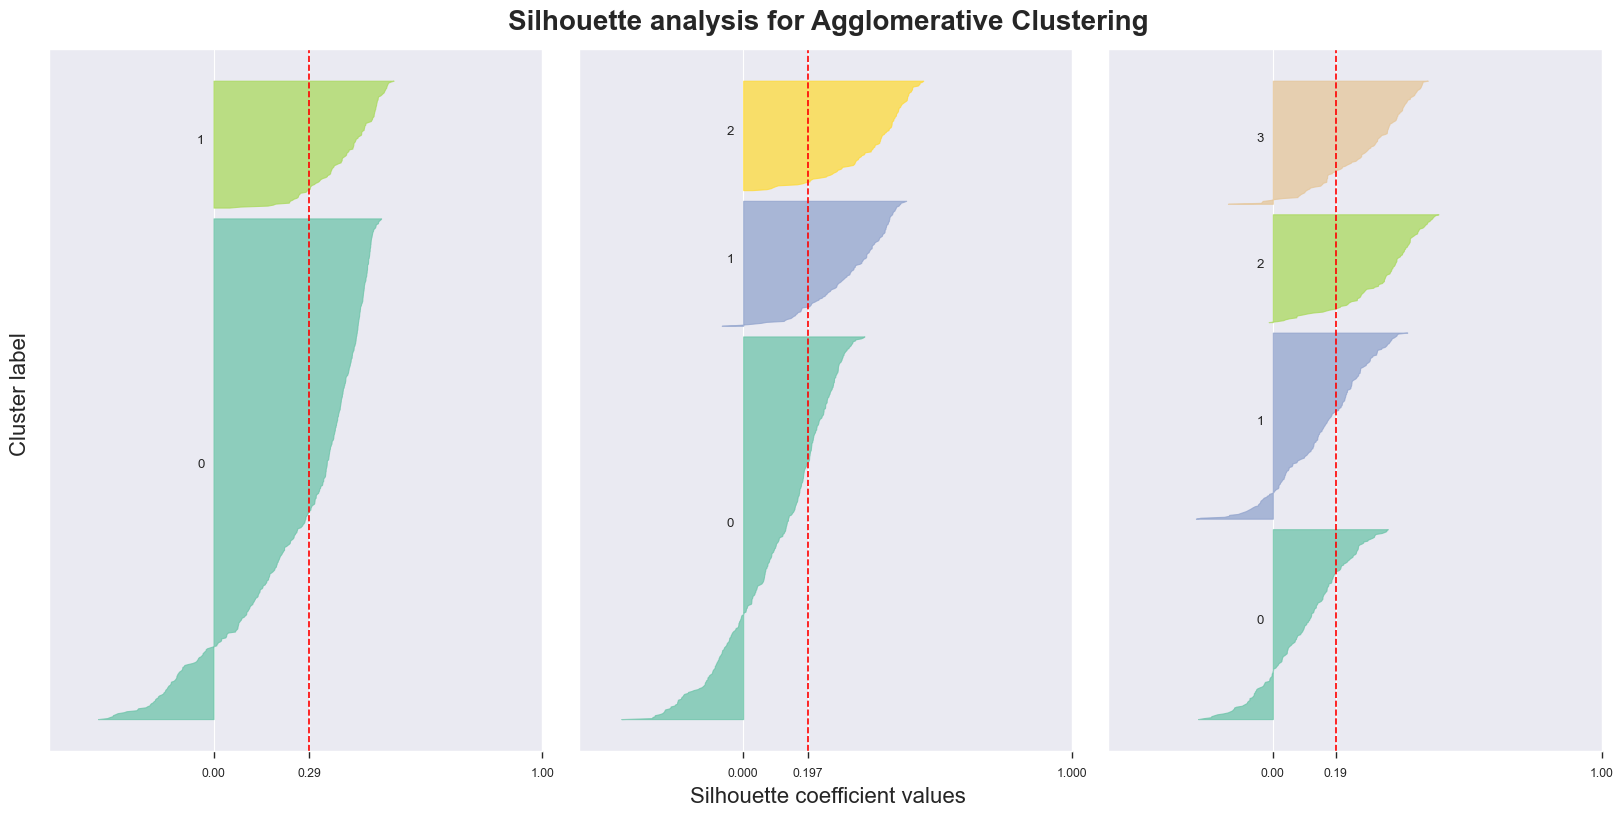

In [146]:
range_n_clusters = range(2,5)
indices = np.array(range_n_clusters) - np.array(range_n_clusters)[0]

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs = axs.flatten()

fig.suptitle("Silhouette analysis for Agglomerative Clustering",
                 fontsize=20, fontweight='bold')

fig.text(0.5, -0.004, "Silhouette coefficient values", ha="center", va="center", size=16)
fig.text(-0.005, 0.5, "Cluster label", ha="center", va="center", rotation=90, size=16)

for idx, n in zip(indices, range_n_clusters):
    model = AgglomerativeClustering(n_clusters=n)
    labels = model.fit_predict(X)
    ax = axs[idx]
    plot_silhouettes(X, n, labels, ax=ax, low_x=-0.5)
    
plt.tight_layout()
    
plt.show()

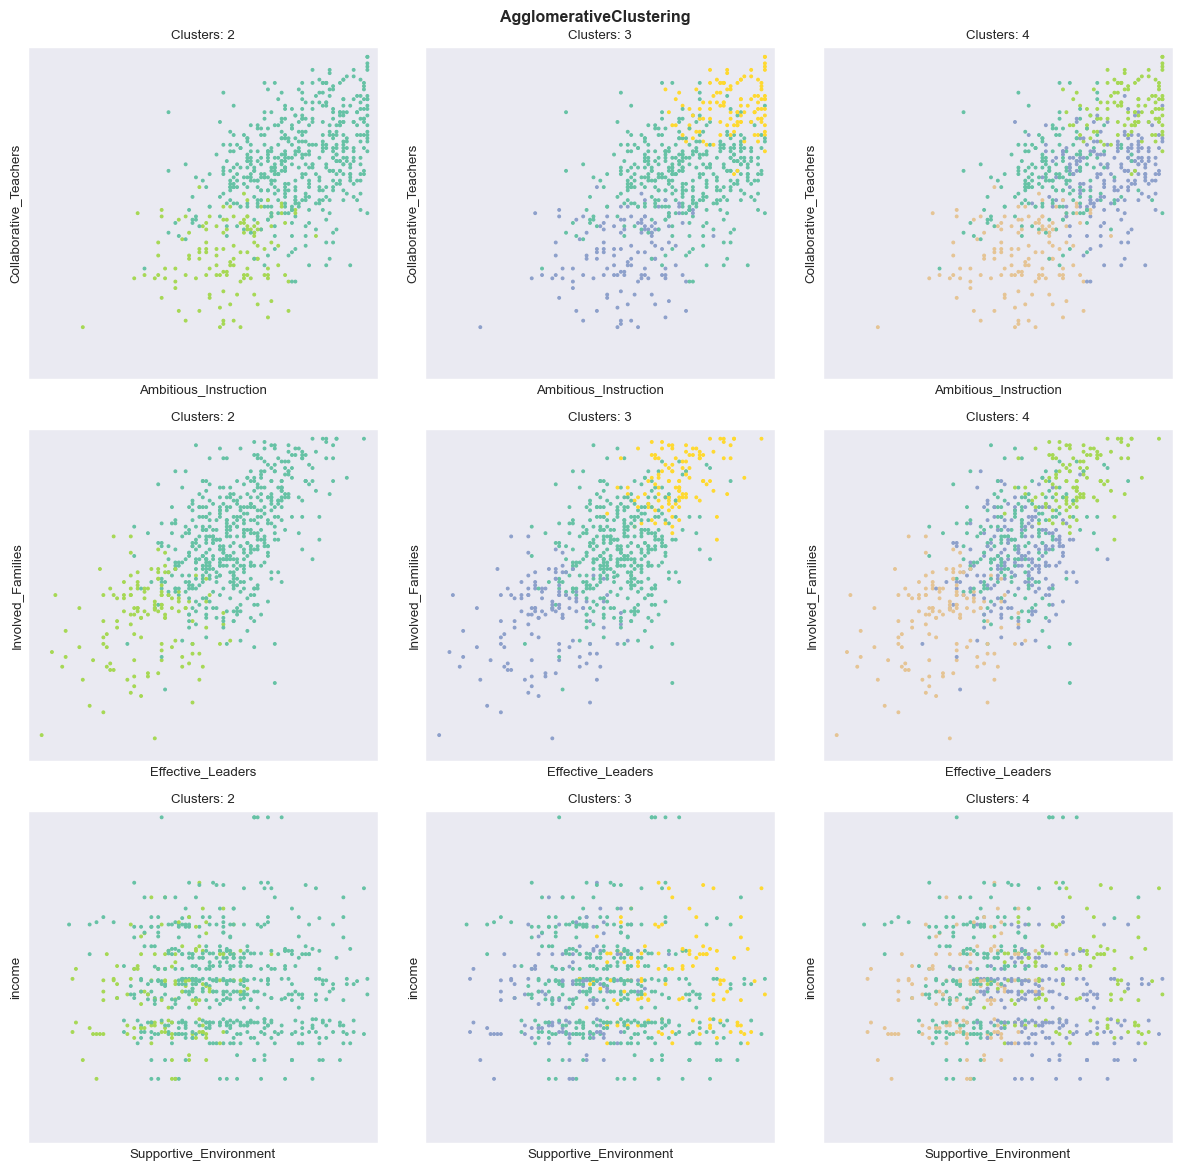

In [159]:
plot_params(AgglomerativeClustering, 'n_clusters', [2, 3, 4])

### Mean-Shift

In [149]:
X = get_fresh_X()

In [150]:
bandwidth = estimate_bandwidth(X)
bandwidth

40.9875536484043

In [151]:
bw_range = np.arange(10, 60, 2)
# ms_cluster_counts = get_cluster_counts(MeanShift, 'bandwidth', bw_range)

# get_cluster_counts takes a long time, so here's the result
ms_cluster_counts = [495, 356, 229, 132, 74, 43, 24, 14, 5, 4, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

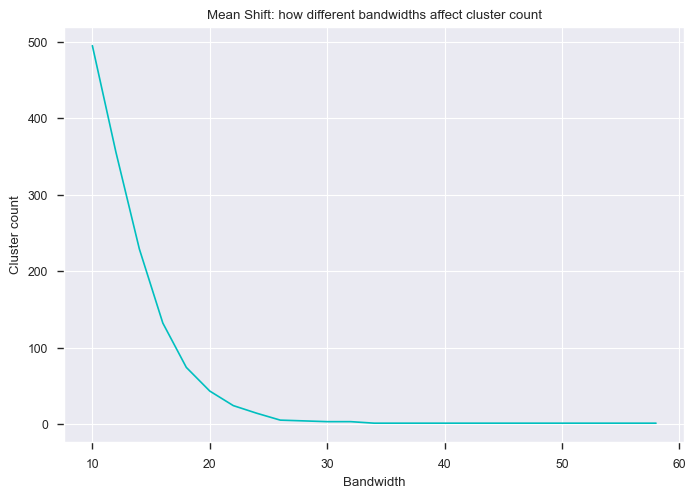

In [152]:
plt.plot(bw_range, ms_cluster_counts, color='c')
plt.xlabel('Bandwidth')
plt.ylabel('Cluster count')
plt.title('Mean Shift: how different bandwidths affect cluster count')
plt.show()

In [153]:
bws = get_final_params(initial_param_values=bw_range,
           cluster_counts=ms_cluster_counts)

parameter value: 30 --- number of clusters: 3
parameter value: 28 --- number of clusters: 4
parameter value: 26 --- number of clusters: 5


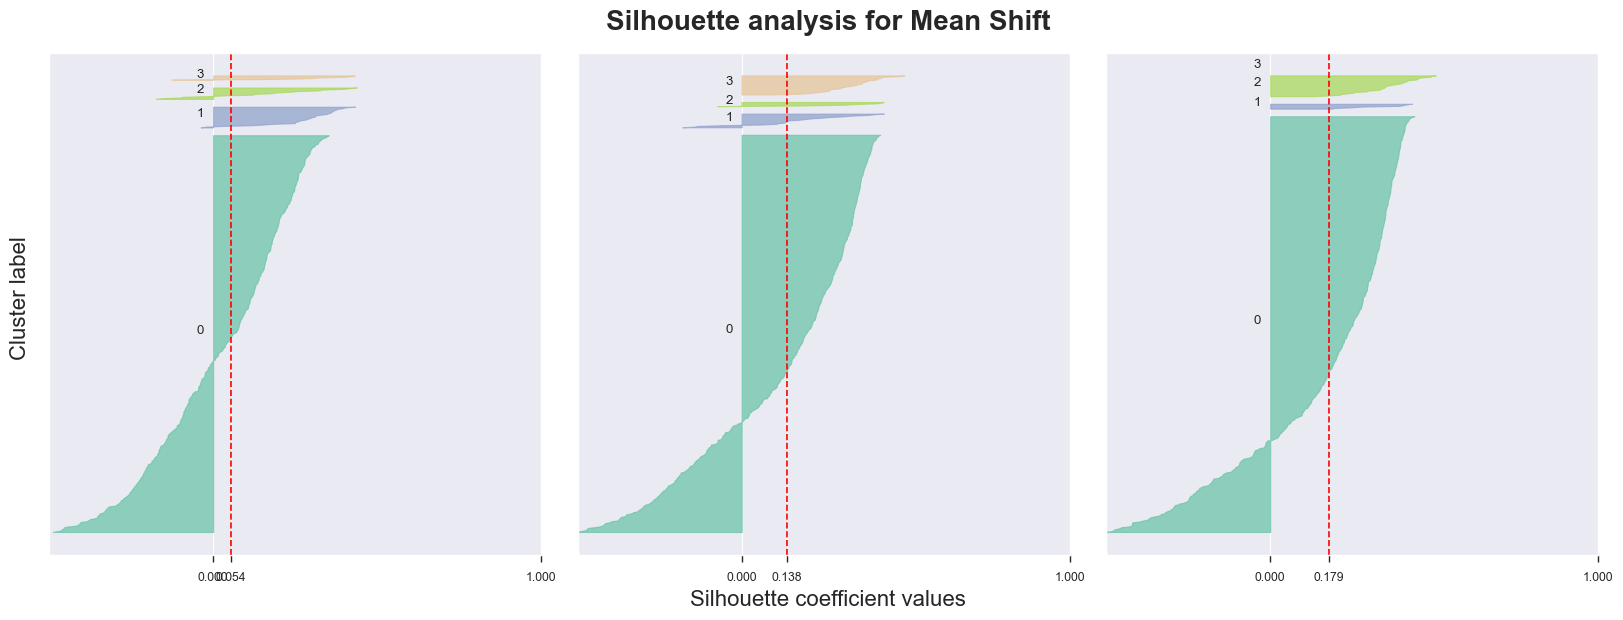

In [157]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs = axs.flatten()

fig.suptitle("Silhouette analysis for Mean Shift",
                 fontsize=20, fontweight='bold')

fig.text(0.5, -0.004, "Silhouette coefficient values", ha="center", va="center", size=16)
fig.text(-0.005, 0.5, "Cluster label", ha="center", va="center", rotation=90, size=16)

for idx, bw in enumerate(bws):
    model = MeanShift(bandwidth=bw)
    labels = model.fit_predict(X)
    ax = axs[idx]
    plot_silhouettes(X, n, labels, ax=ax, low_x=-0.5)
    
plt.tight_layout()
    
plt.show()

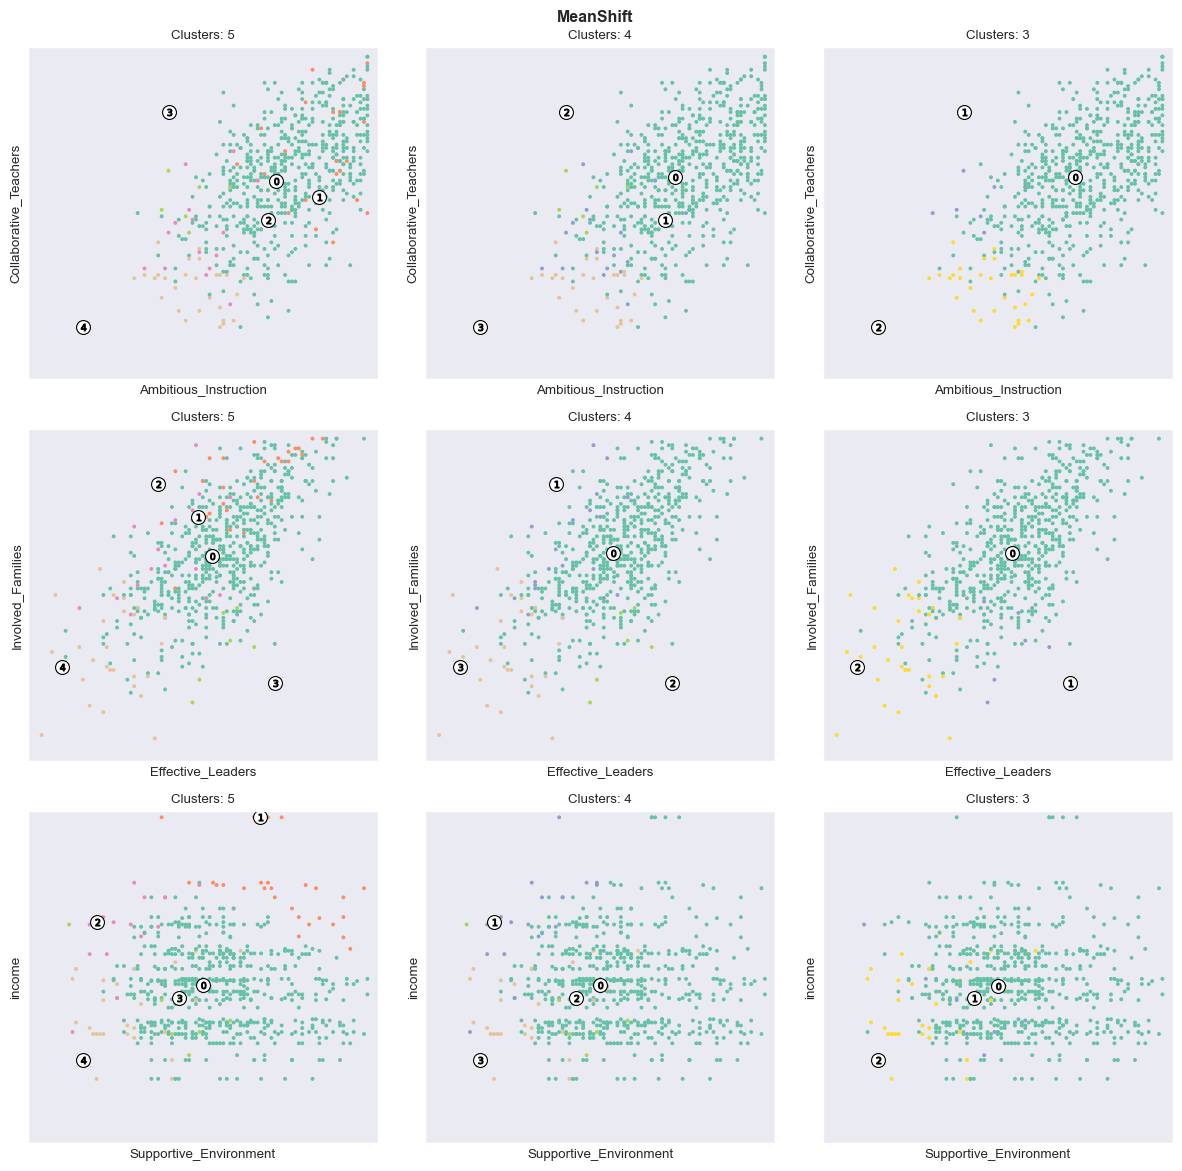

In [162]:
plot_params(MeanShift, 'bandwidth', bws)

"In real use cases we can’t look at the data and realise points are not really in a cluster; we have to take the clustering algorithm at its word."
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#affinity-propagation

### Affinity propagation

In [163]:
X = get_fresh_X()

In [164]:
affinity = AffinityPropagation(random_state=random_state).fit(X)

In [165]:
prefs_range = np.arange(-1000000, 0, 10000)

# ap_cluster_counts = get_cluster_counts(AffinityPropagation, 
#                    'preference', 
#                    np.arange(-1000000, 0, 10000),
#                    {'damping': 0.9, 'random_state': random_state})

# get_cluster_counts can take a long time, so here's the result
ap_cluster_counts = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                     1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 
                     2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 
                     3, 3, 3, 3, 3, 4, 5, 5, 9, 11]

In [166]:
prefs = get_final_params(prefs_range, ap_cluster_counts)

parameter value: -330000 --- number of clusters: 2
parameter value: -170000 --- number of clusters: 3
parameter value: -50000 --- number of clusters: 4
parameter value: -40000 --- number of clusters: 5
parameter value: -20000 --- number of clusters: 9


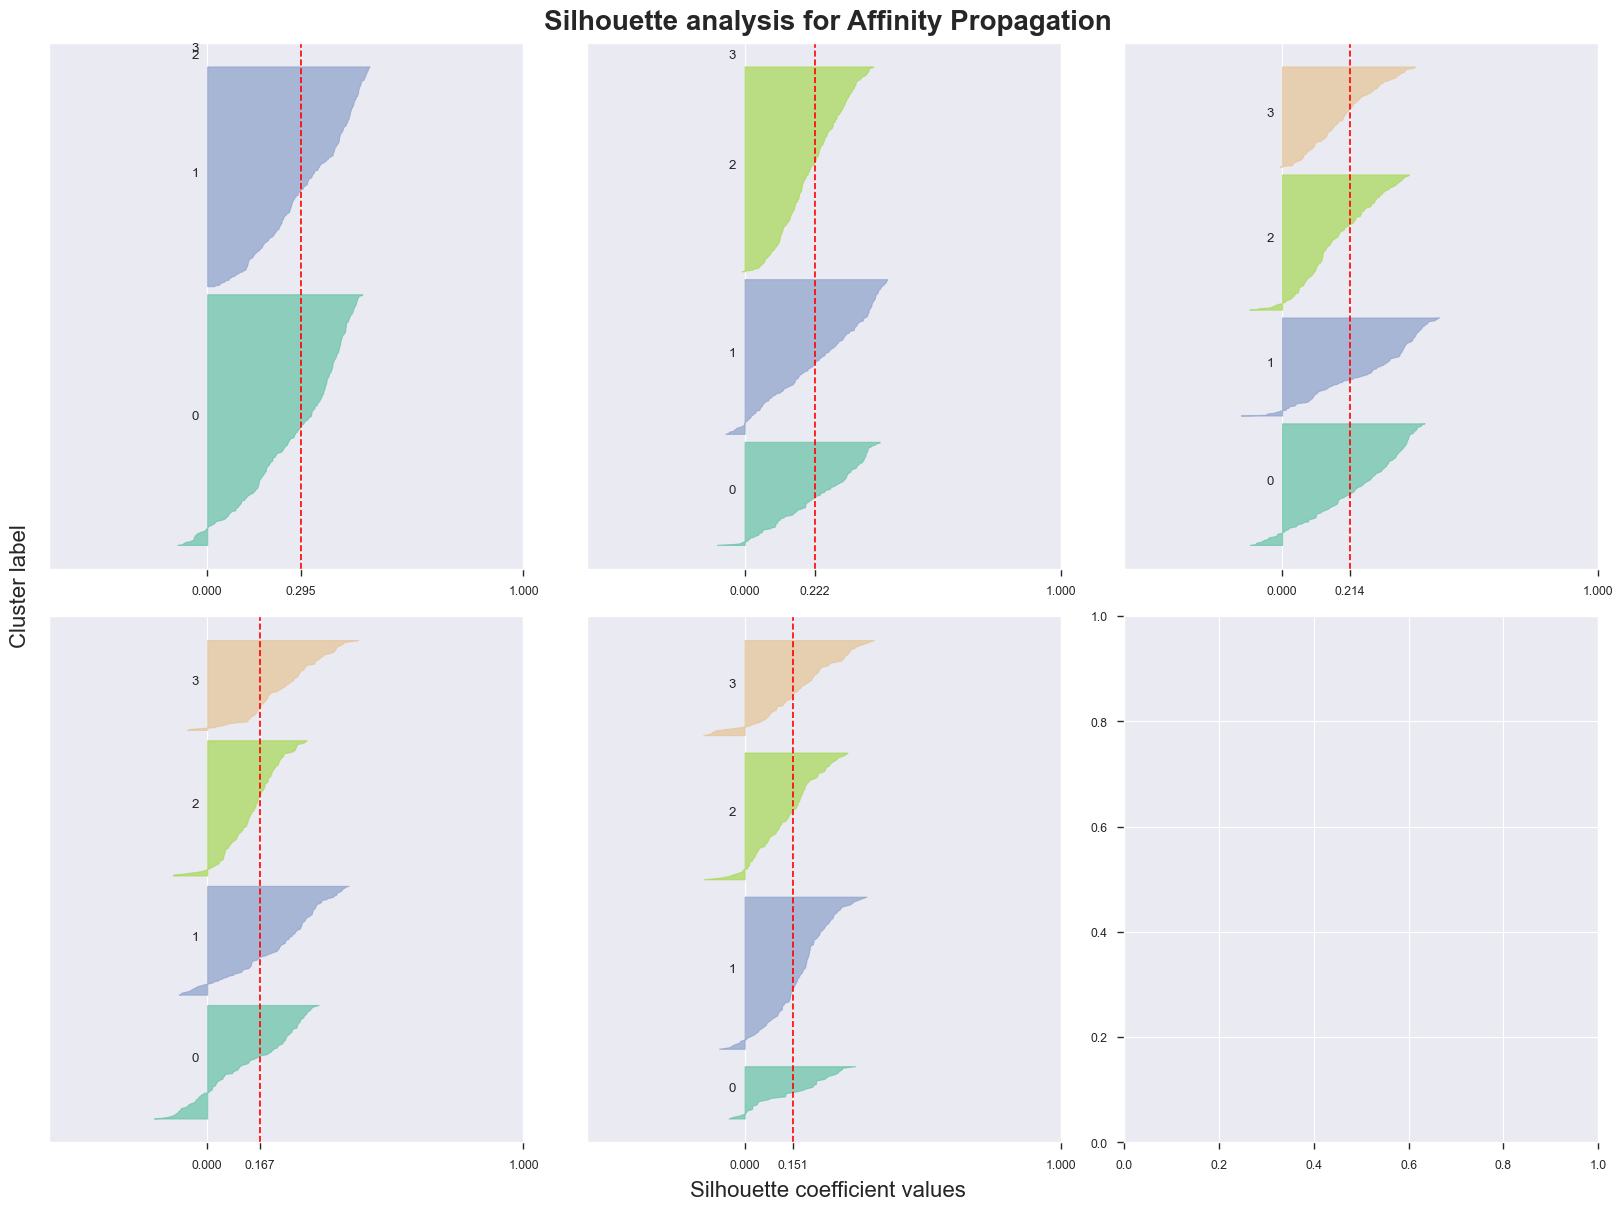

In [169]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
axs = axs.flatten()

fig.suptitle("Silhouette analysis for Affinity Propagation",
                 fontsize=20, fontweight='bold')

fig.text(0.5, -0.004, "Silhouette coefficient values", ha="center", va="center", size=16)
fig.text(-0.005, 0.5, "Cluster label", ha="center", va="center", rotation=90, size=16)

additional_params = {'damping': 0.9, 
                     'random_state': random_state}

for idx, pref in enumerate(prefs):
    model = AffinityPropagation(preference=pref, **additional_params)
    labels = model.fit_predict(X)
    ax = axs[idx]
    plot_silhouettes(X, n, labels, ax=ax, low_x=-0.5)
    
plt.tight_layout()
    
plt.show()

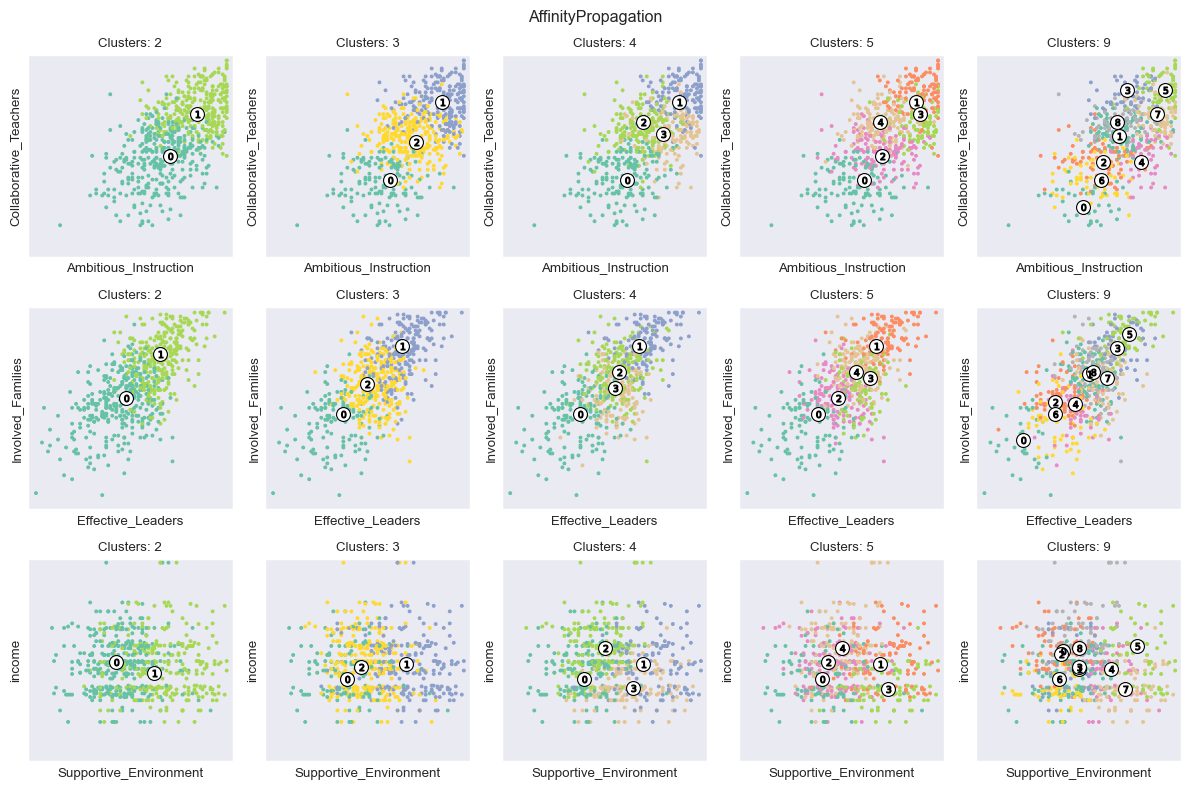

In [154]:
plot_params(AffinityPropagation, 'preference', prefs, additional_params)

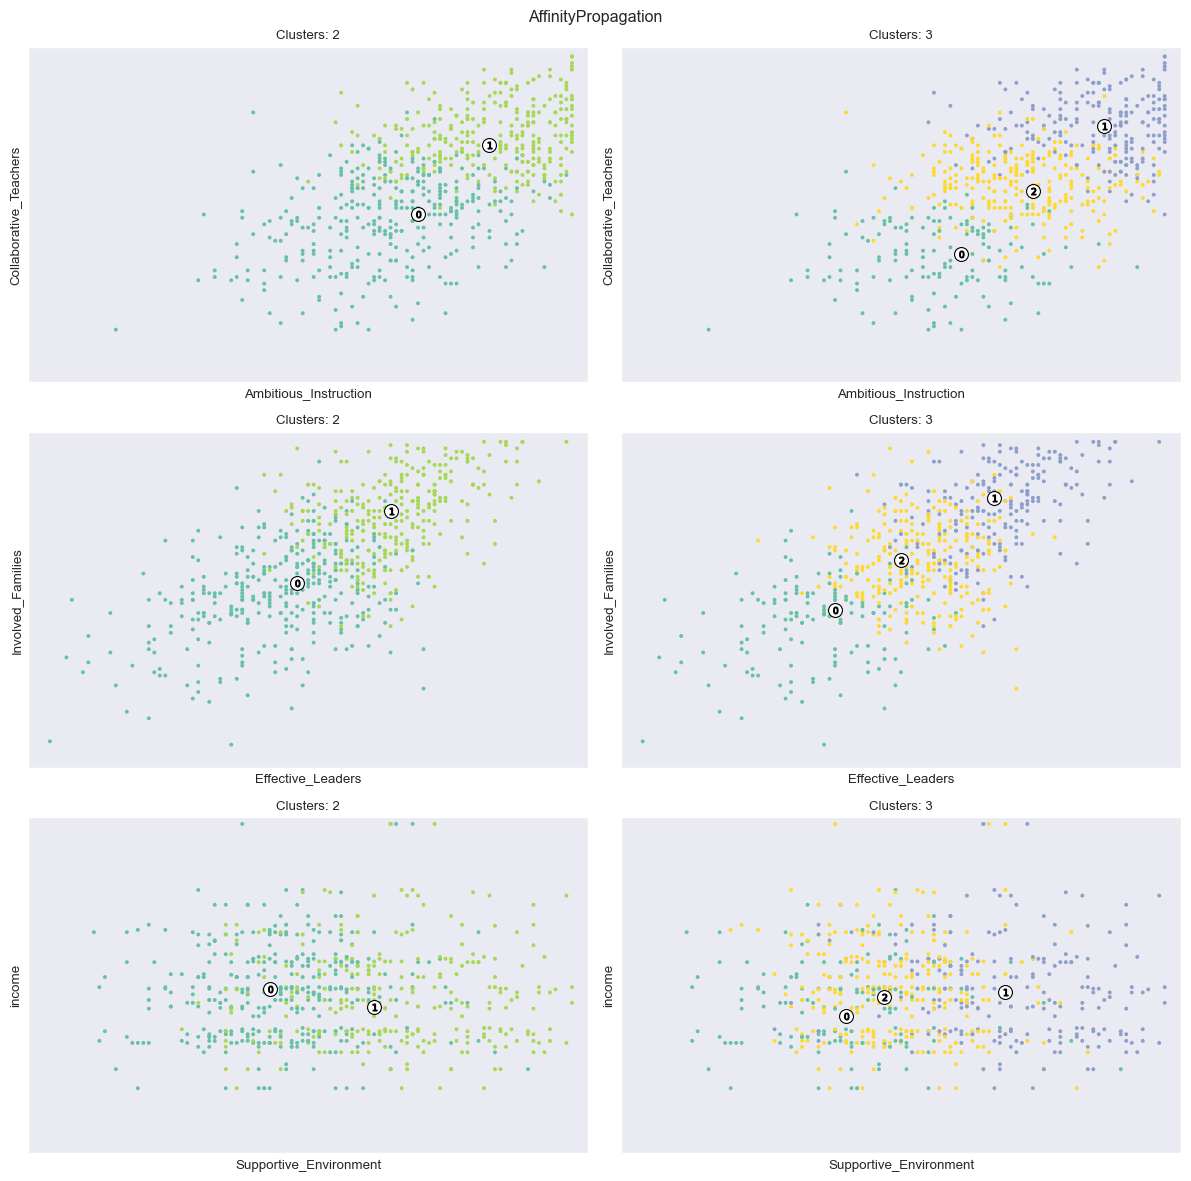

In [153]:
plot_params(AffinityPropagation, 'preference', prefs[0:2], additional_params, figsize=(12,12))

### Gaussian Mixtures

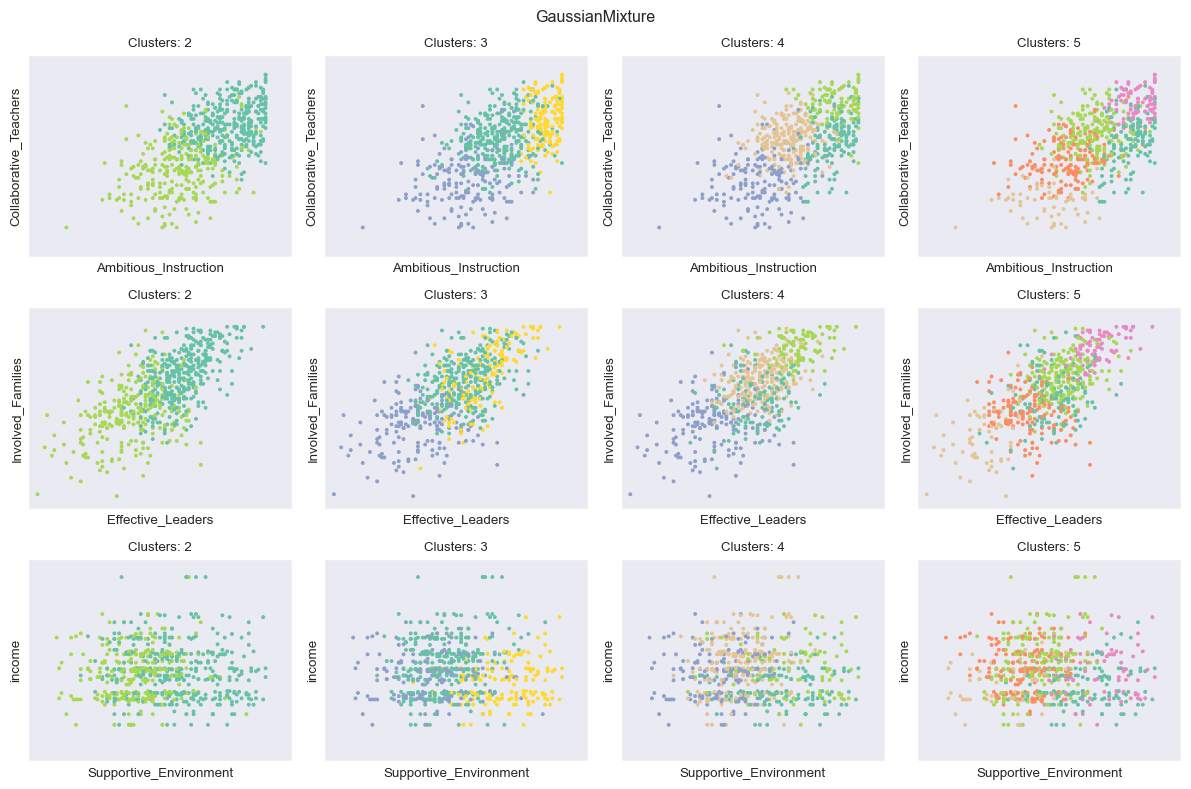

In [86]:
plot_params(GaussianMixture, 'n_components', np.arange(2, 6), {'random_state': random_state})

### Bayesian Gaussian Mixture

In [132]:
bgm = BayesianGaussianMixture(n_components=10, n_init=50, max_iter=1000, random_state=random_state).fit(X)

In [138]:
labels = bgm.predict(X)
centers = bgm.means_

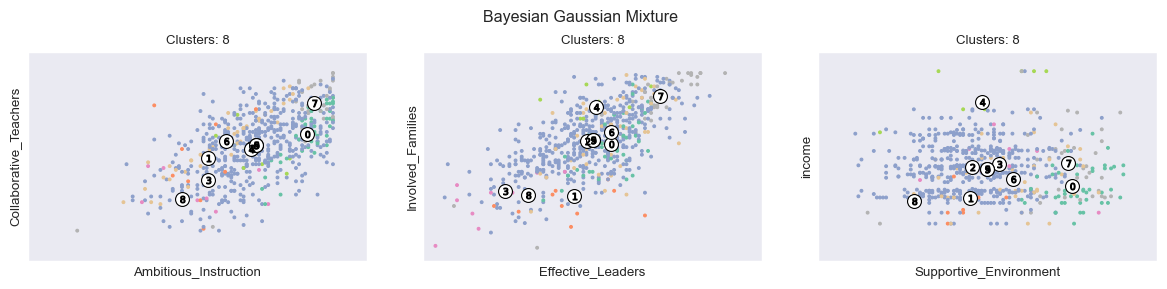

In [148]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
fig.suptitle('Bayesian Gaussian Mixture')

plt.tight_layout()

for i in [0, 1, 2]:
    x = i * 2
    y = (i * 2) + 1
    scatter_labels(bgm, labels, centers, x=x, y=y, ax=axs[i])

### Most promising models

KMeans: 2 or 3 clusters  
AgglomerativeClustering: 2 or 3 clusters  
AffinityPropagation: 2 or 3 clusters  
GaussianMixture: 2 clusters  

In [ ]:
# fig, axs = plt.subplots(2, 4, figsize=(12,8))
# kmeans